In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wikidata.QueryManager import *

# Load Data : sport quotes & occupation of the speakers

The loaded datasets have been obtained during Milestone 2. They contain quotes of sport media from year 2015 to 2020.

In [2]:
# Load dataset containing sport quotes

sport_quotes_2015 = pd.read_csv('ada-sports-quotes/sport-quotes-2015.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2016 = pd.read_csv('ada-sports-quotes/sport-quotes-2016.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2017 = pd.read_csv('ada-sports-quotes/sport-quotes-2017.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2018 = pd.read_csv('ada-sports-quotes/sport-quotes-2018.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2019 = pd.read_csv('ada-sports-quotes/sport-quotes-2019.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2020 = pd.read_csv('ada-sports-quotes/sport-quotes-2020.csv.bz2', compression='bz2', usecols=['qids'])

df_all = pd.concat([sport_quotes_2015, sport_quotes_2016, sport_quotes_2017, sport_quotes_2018, sport_quotes_2019, sport_quotes_2020])
df_all.reset_index(inplace=True, drop=True)
df_all.head()

# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('speaker_attributes.parquet', columns=['party', 'occupation', 'id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [3]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
df_all['qids'] = df_all['qids'].str.strip('[\'\']')
speakers = speaker_attributes[speaker_attributes['id'].isin(df_all['qids'])]

# All sport quotes speakers : occupation distribution

In [4]:
# Concatenate occupations of speakers who have multiples occupations
occupations = []

for i in range(speakers.shape[0]):
    occupations = np.concatenate((occupations, speakers['occupation'].iloc[i]), axis=None)

occupations = pd.DataFrame(occupations, columns=['occupation'])

In [5]:
# Counts the occurences of each occupation and merging the corresponding label
occupation_counts_1_qid_speakers = pd.DataFrame(pd.value_counts(occupations['occupation']))
occupation_counts_label_1_qid_speakers = occupation_counts_1_qid_speakers.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_1_qid_speakers

,count,Label,Description
QID,,,
Q937857,22221,association football player,person who plays association football (soccer)...
Q82955,15766,politician,"person involved in politics, person who holds ..."
Q19204627,10517,American football player,sportsperson who is active in American football
Q33999,8853,actor,person who acts in a dramatic or comic product...
Q1650915,6649,researcher,"person who engages in research, professionally..."
...,...,...,...
Q104224827,1,disco singer,singer who sings disco songs
Q104224740,1,dansband singer,singer who sings in a dansband
Q24387326,1,mythographer,writer on mythology


In [6]:
# Setting label of occupation with count lower than the .99 quantile to 'Others'
threshold_value = occupation_counts_label_1_qid_speakers['count'].quantile(.99)
values_below_thresh = occupation_counts_label_1_qid_speakers['count'] < threshold_value
occupation_counts_label_1_qid_speakers.loc[values_below_thresh,'Label'] = 'Others'

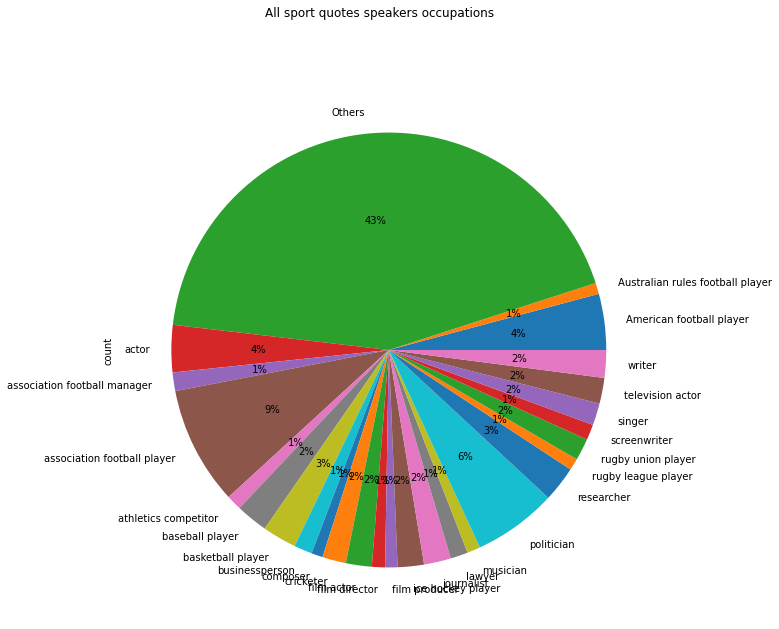

In [7]:
# plot
fig = occupation_counts_label_1_qid_speakers.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='All sport quotes speakers occupations')
plt.savefig('sport_quotes_occupation_distribution.png')

# Speakers with political party : occupation distribution

In [8]:
# Create subset of speakers with political party
politicians = speakers[~(speakers['party'].isna())]

print("Percentage of speakers with political party over sport quotes speakers :")
politicians.shape[0]/speakers.shape[0]*100

Percentage of speakers with political party over sport quotes speakers :


8.77958399673634

In [9]:
# Devide politicians according to their number of occupation 
politiciansbis=politicians
politicians_none_qid = []
politicians_1_qid = []
politicians_many_qid = []

for i in range(politiciansbis.shape[0]):
    if politiciansbis['occupation'].iloc[i] is None:
        politicians_none_qid.append(politiciansbis['occupation'].iloc[i])
    elif len(politiciansbis['occupation'].iloc[i]) == 1 :
           politicians_1_qid.append(politiciansbis['occupation'].iloc[i])
    elif len(politiciansbis['occupation'].iloc[i]) > 1 :
             politicians_many_qid.append(politiciansbis['occupation'].iloc[i])
    else :
             politicians_none_qid.append(politiciansbis['occupation'].iloc[i])

politicians_none_qid = pd.DataFrame(politicians_none_qid, columns=['occupation'])
politicians_1_qid = pd.DataFrame(politicians_1_qid, columns=['occupation'])

In [10]:
# Devide speakers with several occupations based on if one of their occupations is politician
politicians_many_qid_politician = np.array([])
politicians_many_qid_no_politician = np.array([])
nb_politicians_many_qid_politician = 0
nb_politicians_many_qid_no_politician = 0
for item in politicians_many_qid :
    if 'Q82955' in item :
        politicians_many_qid_politician = np.concatenate((politicians_many_qid_politician, item), axis=None)
        nb_politicians_many_qid_politician+=1
    else : 
        politicians_many_qid_no_politician = np.concatenate((politicians_many_qid_no_politician, item), axis=None)
        nb_politicians_many_qid_no_politician+=1

politicians_many_qid_politician = pd.DataFrame(politicians_many_qid_politician, columns=['occupation'])
politicians_many_qid_no_politician = pd.DataFrame(politicians_many_qid_no_politician, columns=['occupation'])

In [11]:
print("Percentage of people with one occupation over sport quotes speakers with a party :")
print(politicians_1_qid.shape[0]/politicians.shape[0]*100)
print("Percentage of people with several occupations including politician over sport quotes speakers with a party :")
print(nb_politicians_many_qid_politician/politicians.shape[0]*100)
print("Percentage of people with several occupations excluding politician over sport quotes speakers with a party :")
print(nb_politicians_many_qid_no_politician/politicians.shape[0]*100)
print("Percentage of people without occupation over sport quotes speakers with a party :")
print(politicians_none_qid.shape[0]/politicians.shape[0]*100)

Percentage of people with one occupation over sport quotes speakers with a party :
59.03194578896418
Percentage of people with several occupations including politician over sport quotes speakers with a party :
33.47531461761859
Percentage of people with several occupations excluding politician over sport quotes speakers with a party :
6.040658276863504
Percentage of people without occupation over sport quotes speakers with a party :
1.452081316553727


In [12]:
# Counts the occurences of each occupation and merging the corresponding label FOR 1 OCCUPATION
occupation_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid['occupation']))
occupation_counts_label_1_qid = occupation_counts_1_qid.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_1_qid.head()
occupation_counts_label_1_qid.tail()

# Counts the occurences of each occupation and merging the corresponding label FOR MANY OCCUPATIONS - POLITICIAN
occupation_counts_many_qid_politician = pd.DataFrame(pd.value_counts(politicians_many_qid_politician['occupation']))
occupation_counts_label_many_qid_politician = occupation_counts_many_qid_politician.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_many_qid_politician.head()
occupation_counts_label_many_qid_politician.tail()

# Counts the occurences of each occupation and merging the corresponding label FOR MANY OCCUPATIONS - NO POLITICIAN
occupation_counts_many_qid_no_politician = pd.DataFrame(pd.value_counts(politicians_many_qid_no_politician['occupation']))
occupation_counts_label_many_qid_no_politician = occupation_counts_many_qid_no_politician.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_many_qid_no_politician

,count,Label,Description
QID,,,
Q33999,234,actor,person who acts in a dramatic or comic product...
Q10800557,216,film actor,actor who appears in films
Q10798782,216,television actor,actor who performs on television
Q36180,162,writer,person who uses written words to communicate i...
Q40348,156,lawyer,legal professional who helps clients and repre...
...,...,...,...
Q10669499,1,naval officer,commissioned officer serving in a navy
Q721834,1,manager,supporting character in professional wrestling
Q10730252,1,radio DJ,someone who broadcasts music on the radio


In [13]:
# Setting label of occupation with count lower than the .98 quantile to 'Others' FOR 1 OCCUPATION
threshold_value = occupation_counts_label_1_qid['count'].quantile(.98)
values_below_thresh = occupation_counts_label_1_qid['count'] < threshold_value
print(occupation_counts_label_1_qid.loc[values_below_thresh,'Label'])
occupation_counts_label_1_qid.loc[values_below_thresh,'Label'] = 'Others'

# Setting label of occupation with count lower than the .98 quantile to 'Others' FOR MANY OCCUPATIONS - POLITICIAN
occupation_counts_label_many_qid_politician = occupation_counts_label_many_qid_politician[occupation_counts_label_many_qid_politician['Label']!='politician']
threshold_value = occupation_counts_label_many_qid_politician['count'].quantile(.98)
values_below_thresh = occupation_counts_label_many_qid_politician['count'] < threshold_value
print(occupation_counts_label_many_qid_politician.loc[values_below_thresh,'Label'])
occupation_counts_label_many_qid_politician.loc[values_below_thresh,'Label'] = 'Others'

# Setting label of occupation with count lower than the .98 quantile to 'Others' FOR MANY OCCUPATIONS - NO POLITICIAN
threshold_value = occupation_counts_label_many_qid_no_politician['count'].quantile(.98)
values_below_thresh = occupation_counts_label_many_qid_no_politician['count'] < threshold_value
print(occupation_counts_label_many_qid_no_politician.loc[values_below_thresh,'Label'])
occupation_counts_label_many_qid_no_politician.loc[values_below_thresh,'Label'] = 'Others'

QID
Q193391                                     diplomat
Q19204627                   American football player
Q188094                                    economist
Q36180                                        writer
Q15627169                             trade unionist
                              ...                   
Q2986228                          sports commentator
Q2462658                                     manager
Q1518581     list of Ministers of Interior of Russia
Q29169143                             data scientist
Q836971                              party secretary
Name: Label, Length: 162, dtype: object
QID
Q806798                  banker
Q33999                    actor
Q185351                  jurist
Q212238           civil servant
Q47064       military personnel
                    ...        
Q16947320         geopolitician
Q97767991                   NaN
Q730242              test pilot
Q6859454          web developer
Q46961                 gangster
Name: Label, Leng

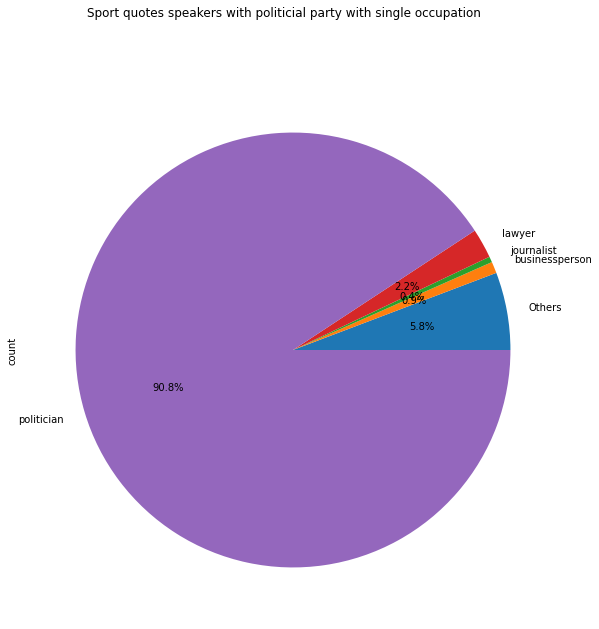

In [14]:
# plot
fig = occupation_counts_label_1_qid.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.1f%%', title='Sport quotes speakers with politicial party with single occupation')
plt.savefig('politicians_occupation_distribution_1_occupation.png')

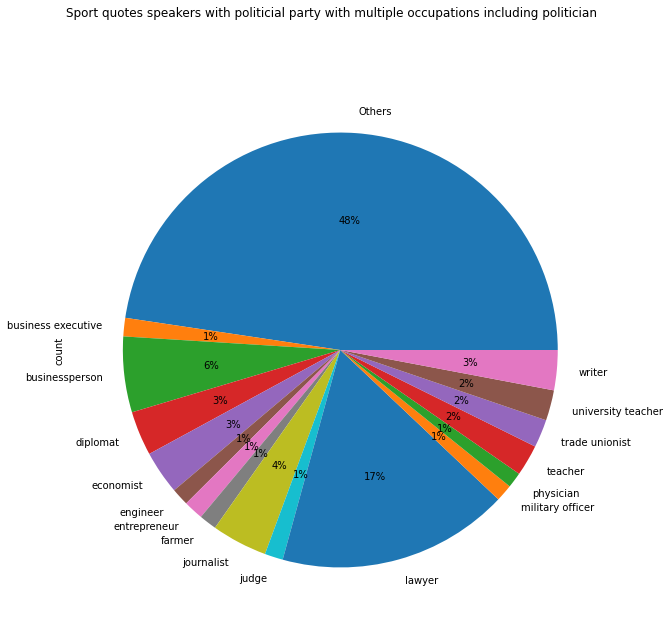

In [15]:
# plot
fig = occupation_counts_label_many_qid_politician.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Sport quotes speakers with politicial party with multiple occupations including politician')
plt.savefig('politicians_occupation_distribution_politics.png')

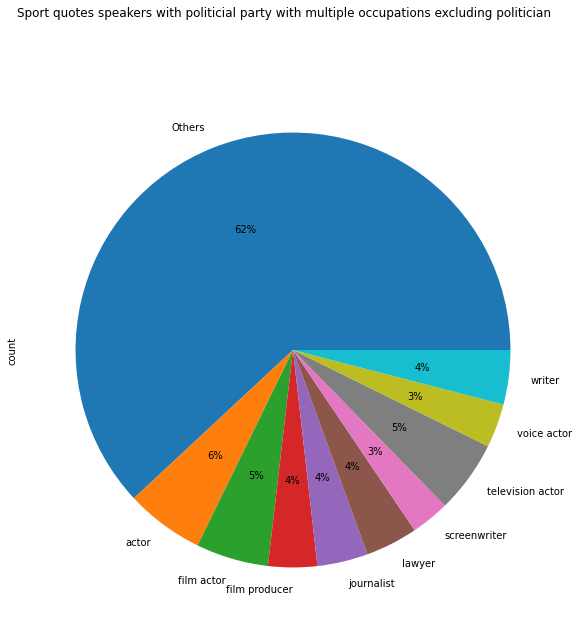

In [16]:
# plot
fig = occupation_counts_label_many_qid_no_politician.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Sport quotes speakers with politicial party with multiple occupations excluding politician')
plt.savefig('politicians_occupation_distribution_1_non_politics.png')

# Load Data : politicians sport quotes & party of politicians

Politicians sport quotes refers at quotations said by speakers having a political party. Theses datasets from year 2015 to 2020 have been obtained during Milestone 2.

In [17]:
#loading quotes dataset

df_2015 = pd.read_csv('quotebank_politician_with_party/2015.csv.bz2', compression='bz2')
df_2016 = pd.read_csv('quotebank_politician_with_party/2016.csv.bz2', compression='bz2')
df_2017 = pd.read_csv('quotebank_politician_with_party/2017.csv.bz2', compression='bz2')
df_2018 = pd.read_csv('quotebank_politician_with_party/2018.csv.bz2', compression='bz2')
df_2019 = pd.read_csv('quotebank_politician_with_party/2019.csv.bz2', compression='bz2')
df_2020 = pd.read_csv('quotebank_politician_with_party/2020.csv.bz2', compression='bz2')


df = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019, df_2020])
df.reset_index(inplace=True, drop=True)

# Which political parties or politicians are the most present in the sports quotes?

## Parties

In [18]:
# Only keeping the first qid in the party feature
politicians_1_qid = df['current_party']
politicians_1_qid.shape

# Counts the occurences of each party and merging the corresponding label
party_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid))
party_counts_label_1_qid = party_counts_1_qid.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'current_party': 'count'})
party_counts_label_1_qid.head(3)

,count,Label,Description
QID,,,
Q29468,105568,Republican Party,major political party in the United States
Q29552,84733,Democratic Party,political party in the United States
Q10230,14266,Bharatiya Janata Party,major political party in India


In [19]:
# Setting label of party with count lower than the .99 quantile to 'Others'
threshold_value = party_counts_label_1_qid['count'].quantile(.99)
values_below_thresh = party_counts_label_1_qid['count'] < threshold_value
party_counts_label_1_qid.loc[values_below_thresh,'Label'] = 'Others'

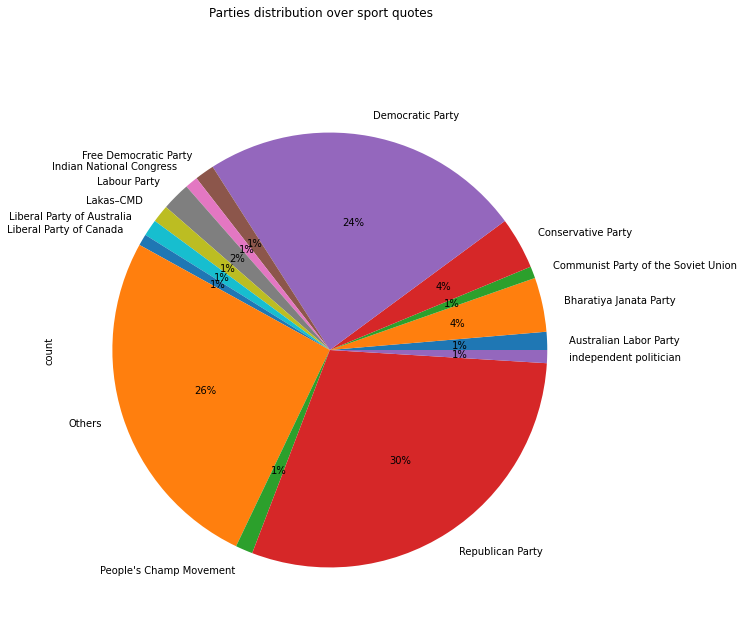

In [20]:
fig = party_counts_label_1_qid.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Parties distribution over sport quotes')
plt.savefig('most_present_political_parties.png')

## Politicians

In [21]:
# Only keeping the first qid in the party feature
politicians_1_qid = df['speaker']
politicians_1_qid

# Counts the occurences of each party and merging the corresponding label
politician_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid))
politician_counts_label_1_qid = politician_counts_1_qid.rename(columns={'speaker': 'count'})
politician_counts_label_1_qid

,count
President Donald Trump,9295
Gabe Kapler,6470
Roger Goodell,6409
Adam Silver,5914
Thomas Bach,5076
...,...
Mohamed ElBaradei,1
Andrej Danko,1
Rosol Wahid,1
Moeletsi Mbeki,1


In [22]:
# Aggregate Donald Trump quotes
politician_counts_label_1_qid.loc['President Donald Trump', 'count'] = politician_counts_label_1_qid.loc['President Donald Trump', 'count'] + politician_counts_label_1_qid.loc['President Trump', 'count']
politician_counts_label_1_qid = politician_counts_label_1_qid.drop(index='President Trump')

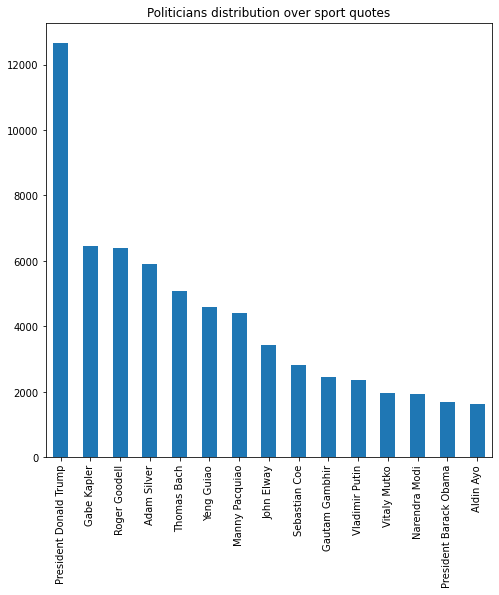

In [23]:
fig = politician_counts_label_1_qid[0:15].sort_values(by='count', ascending=False).plot(kind='bar',legend=False, figsize=(8, 8), log=False, title='Politicians distribution over sport quotes')
fig.get_figure().savefig('most_present_politicians.png')

In [24]:
print("Percentage of President Donald Trump presence in politician sport quotes :")
politician_counts_label_1_qid.loc['President Donald Trump', 'count']/sum(politician_counts_label_1_qid['count'])*100

Percentage of President Donald Trump presence in politician sport quotes :


3.4450920579583837

In [25]:
print("Times President Donald Trump is more cited than the second politician (Gabe Kapler) in politician sport quotes :")
politician_counts_label_1_qid.loc['Gabe Kapler', 'count']/politician_counts_label_1_qid.loc['President Donald Trump', 'count']

Times President Donald Trump is more cited than the second politician (Gabe Kapler) in politician sport quotes :


0.511502885603605